# **Group Assignment Task2 : Predicting Critical Temperature Using `Spark MLlib`**

**Group Name** : Group06

**Tutorial Group** : T01

**Task number** : Task2

**Participants** :

Pyae Sone Hein (8221522)

Kaung Myat Soe (8218924)

Su Thet Min Htet (8221947)

Keerthana Sankaramani (7765733)

Alicia Thum Hew Yan (8234681)

Lim Kuan, Francis (Lin Kang) (7912961)




# **Introduction**

A superconductor is a substance that conducts electricity without resistance when it becomes colder than a critical temperature. The intention of notebook is to implement an end-to-end data mining project by using `Spark Mllib` to predict critical temperature in the superconductivity dataset.

## **List of main steps**

Here are the main steps that we will go through:

(1) Get the Data

(2) Exploratory Data Analysis

(3) Prepare the Data for Machine Learning Algorithms

(4) Select and train the models

(5) Fine-tune the models

(6) Evaluate the model outcomes


## **Algorithm Used**

Since it is a regression problem, we used the following algorithms:


*   Linear Regression
*   Decision Tree
*   Random Forest

# **Summary**

The temperature of at which a material becomes superconductive is what we are trying to predict in this task.

To frame the problem , it is clearly a typical supervised learning task and it is also regression problem. Thus, Root Mean Square Error($RMSE$) is chosen as measure to perform this problem.

In order to obtain understanding of the dataset, the project starts with an exploratory data analysis (EDA) phase. Each Data Quality are being checked such as checking missing values, checking outliers, checking correlations and attribute combinations. After the EDA, Data Preprocessing is performed.Once the data is prepared, the selected models will be trained and perform fine-tuning as well. After training the models, they  will be evaluated on a test dataset to predict the temperature of superconductivity with the highest possible R2 score and lowest possible RMSE.

# **Importing Related Libraries**

The following are the necessary libraries that will be used throughout the project. To work with PySpark by automatically configuring the environment, it is required to install both `pyspark` and `findspark` as well.

In [ ]:
!pip install pyspark py4j
!pip install spark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=c4c5735b8636b1bc6344df4a1447f374f1ccd852f084510bc020712345c19017
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58748 sha256=6c43057c1d60a216f8ce9d6b16146af03255a79fe64cb7ebb09178faf7c82f8c
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark


In [ ]:
import os
import sys
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use(style='seaborn')

from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Bucketizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml import Transformer
from pyspark.ml import Pipeline

<ipython-input-1-555de2dd63a8>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style='seaborn')


# **Get the Dataset**


To download the data, it is requried to be mounted to the content of Google Drive folder.

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


Next, we will set up the Spark session to handle a large dataset with increased memory allocation.

In [ ]:
# Configure Spark session before creation
conf = SparkConf() \
    .setAppName("Superconductivity") \
    .set("spark.driver.memory", "15g") \
    .set("spark.executor.memory", "15g")



After that, the dataset is fetched from the 'train.csv' which is stored in "dataset" folder of our workspace. Now, the CSV file is read into a Spark DataFrame with consider the first row as column headers, and `inferSchema` set to True to automatically detect data types.

In [ ]:
default_path = "/content/drive/My Drive/CSCI316_GP_Assignment/dataset/train.csv"
print(f"Default path is set to: {default_path}")
user_path = input("If you have a different path, please enter it here. Otherwise, press Enter to use the default path: ")

# Use the user-specified path or the default path
path = user_path if user_path else default_path

# Create a Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Read the CSV file into a Spark DataFrame
scDF = spark.read.csv(path, header=True, inferSchema=True)


Default path is set to: /content/drive/My Drive/CSCI316_GP_Assignment/dataset/train.csv
If you have a different path, please enter it here. Otherwise, press Enter to use the default path: 


## **Take a Quick Look at the Data Structure**

For now, let's print the shape of the dataframe.

In [ ]:
print((scDF.count(), len(scDF.columns)))

(21263, 82)


There are altogether $21263$ instances and $82$ columns in the dataset.

We will also take a look at quick description of the dataset as well.

In [ ]:
scDF.printSchema()

root
 |-- number_of_elements: integer (nullable = true)
 |-- mean_atomic_mass: double (nullable = true)
 |-- wtd_mean_atomic_mass: double (nullable = true)
 |-- gmean_atomic_mass: double (nullable = true)
 |-- wtd_gmean_atomic_mass: double (nullable = true)
 |-- entropy_atomic_mass: double (nullable = true)
 |-- wtd_entropy_atomic_mass: double (nullable = true)
 |-- range_atomic_mass: double (nullable = true)
 |-- wtd_range_atomic_mass: double (nullable = true)
 |-- std_atomic_mass: double (nullable = true)
 |-- wtd_std_atomic_mass: double (nullable = true)
 |-- mean_fie: double (nullable = true)
 |-- wtd_mean_fie: double (nullable = true)
 |-- gmean_fie: double (nullable = true)
 |-- wtd_gmean_fie: double (nullable = true)
 |-- entropy_fie: double (nullable = true)
 |-- wtd_entropy_fie: double (nullable = true)
 |-- range_fie: double (nullable = true)
 |-- wtd_range_fie: double (nullable = true)
 |-- std_fie: double (nullable = true)
 |-- wtd_std_fie: double (nullable = true)
 |-- mea

We can see that all the data type of attributes are numerical.

Next, we will look out few rows.

In [ ]:
scDF.show(truncate=False)

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+----------------+-------------------+--------+----------------+----------------+----------------+----------------+-----------------+---------+----------------+----------------+----------------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+----------------+-----------------+-----------------+-------------------+-------------+-----------------+----------------+----------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+---------------

From the table, we can see that some of the feature values are very small, indicating that they might need to be scaled or normalized before being used in a machine learning model.Additionally, we can see that there are no missing values in the table.

Since we're trying to predict `'critical_temp'`, let's visualize its distribution and pair plot the other selcted random features to see relationships wtih it.

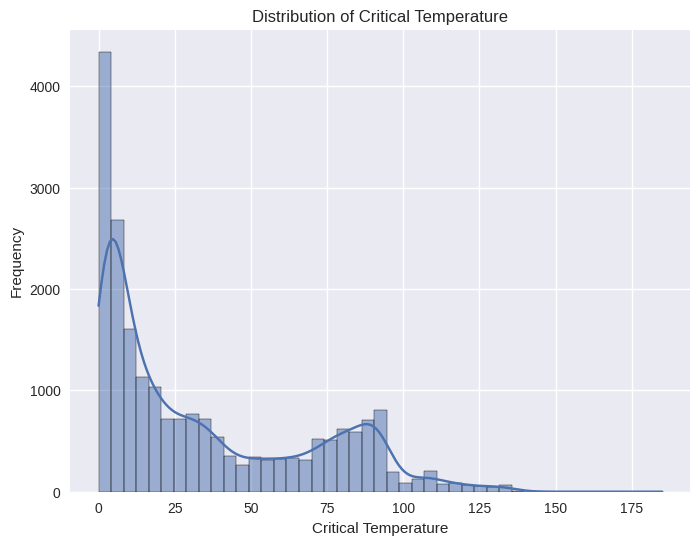

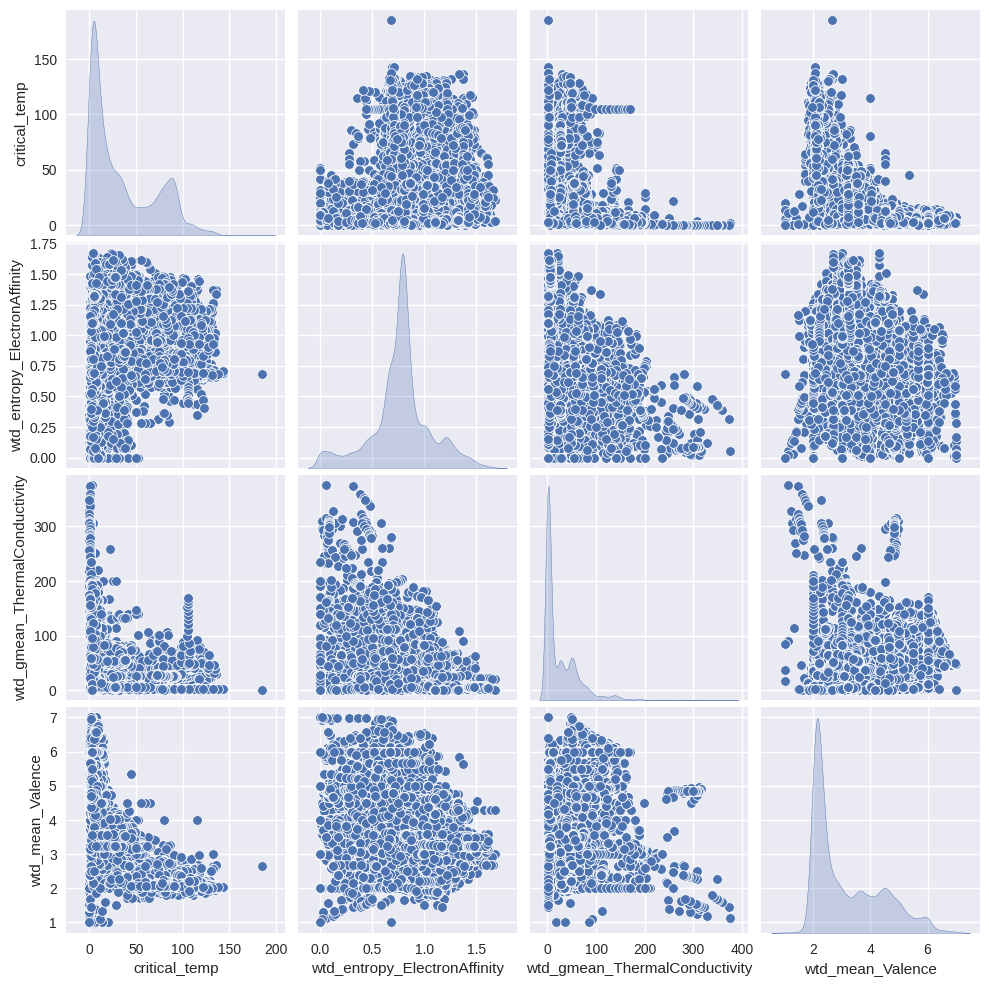

In [ ]:
pandas_df = scDF.toPandas()

plt.figure(figsize=(8, 6))
sns.histplot(pandas_df['critical_temp'], kde=True)
plt.title('Distribution of Critical Temperature')
plt.xlabel('Critical Temperature')
plt.ylabel('Frequency')
plt.show()

sns.pairplot(pandas_df[['critical_temp', 'wtd_entropy_ElectronAffinity', 'wtd_gmean_ThermalConductivity', 'wtd_mean_Valence']], diag_kind='kde')
plt.show()


The pair plot visualizations provide valuable insights into the relationships between the 'critical_temp' and the selected features.

Examining the off-diagonal plots, we can discern potential correlations between variables. The scatter plot between '`critical_temp`' and `'wtd_entropy_ElectronAffinity`' hints at a positive correlation, implying that materials with higher weighted entropy of electron affinity tend to have higher critical temperatures.

Similarly, the plot between `'critical_temp'` and `'wtd_gmean_ThermalConductivity`' suggests a negative correlation, indicating that materials with higher weighted geometric mean of thermal conductivity may have lower critical temperatures.

However, the relationship between `'critical_temp'` and `'wtd_mean_Valence'` appears less clear, with no strong linear correlation readily apparent.

These initial observations from the pair plot can guide us further investigation and feature engineering efforts to develop predictive models for critical temperature.

Before we look at data any further, we shall now proceed to create a train and test set.

## **(1) Splitting the dataset into train(80%) and test(20%)**

Since the `critical_temp` is a continuous numerical attribute, we need to create a bin attribute.Binning can be particularly useful when we want to group continuous variables to reduce noise, enhance model performance, or create categorical features that are easier to interpret.

Here, we are using the **Bucketizer** from PySpark's `ml.feature` module to bin the `'critical_temp'` column into four discrete categories based on specified splits. The resulting binned data is stored in a new column called `'critical_temp_bins'`. This new binned feature will allow us to analyze the distribution of 'critical_temp' values within these defined ranges and potentially use this feature in our subsequent machine learning models.

In [ ]:
splits = [0.0, 10.0, 50.0, 100.0, float('inf')]
labels = [1.0, 2.0, 3.0, 4.0]
bucketizer = Bucketizer(splits=splits, inputCol="critical_temp", outputCol="critical_temp_bins")
scDF = bucketizer.setHandleInvalid("keep").transform(scDF)

# Display the distribution of binned categories
scDF.groupBy("critical_temp_bins").count().show()

+------------------+-----+
|critical_temp_bins|count|
+------------------+-----+
|               0.0| 7729|
|               1.0| 7155|
|               3.0|  802|
|               2.0| 5577|
+------------------+-----+



Now, we will split the dataset into training and test sets to evaluate the performance of the model. Here, I implement a custom function `stratified_train_test_split` to perform a stratified split based on  `critical_temp_bins`. This can also make sure that the train and test sets are representative of the original data distribution, especially for models sensitive to data imbalances.

In [ ]:
def stratified_train_test_split(
    df: SparkDataFrame,
    stratify_column: str,
    train_fraction: float = 0.8,
    seed: int = 42,
):
    unique_col = "unique_id_col"
    df = df.withColumn(unique_col, F.monotonically_increasing_id())

    # Create stratified train set
    train_fraction_dict = (
        df.select(stratify_column)
        .distinct()
        .withColumn("fraction", F.lit(train_fraction))
        .rdd.collectAsMap()
    )
    df_train = df.stat.sampleBy(stratify_column, train_fraction_dict, seed)
    df_remaining = df.join(df_train, on=unique_col, how="left_anti")

    # The test set is the remaining data
    df_test = df_remaining

    # Drop the unique identifier column
    df_train = df_train.drop(unique_col)
    df_test = df_test.drop(unique_col)

    return df_train, df_test


In [ ]:
strat_train_set, strat_test_set = stratified_train_test_split(scDF, 'critical_temp_bins', train_fraction=0.8, seed=42)

We can check whether it is splitted successfully or not by printing the size of of train and test set.

In [ ]:
# Print the dataset
print(f'Train data set size: {strat_train_set.count()} records')
print(f'Test data set size: {strat_test_set.count()} records')

Train data set size: 17157 records
Test data set size: 4106 records


After that, it is important to drop the `"critical_temp_bins"` in each separate train and test set.

In [ ]:
strat_train_set = strat_train_set.drop("critical_temp_bins")
strat_test_set = strat_test_set.drop("critical_temp_bins")

# **Exploratory Data Analysis(EDA)**

Now, we will go a little bit more in depth to discover and visualize the data to gain insights.

While exploring the data, we are going to put the test set aside and only exploring the `strat_train_set`. We will create a copy of it so that we can play with it without harming the original one.

In [ ]:
scCopy = strat_train_set

## **Looking for Missing Values**

Let's check whether they have missing values or not.

In [ ]:
missing_values = scCopy.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in scCopy.columns])
missing_values.show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+---------------+-------------------+--------+------------+---------+-------------+-----------+---------------+---------+-------------+-------+-----------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+-------------+-----------------+---------------+-------------------+-------------+-----------------+-----------+---------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+------------------------+---------------+-------------------+----

In a visualize way,

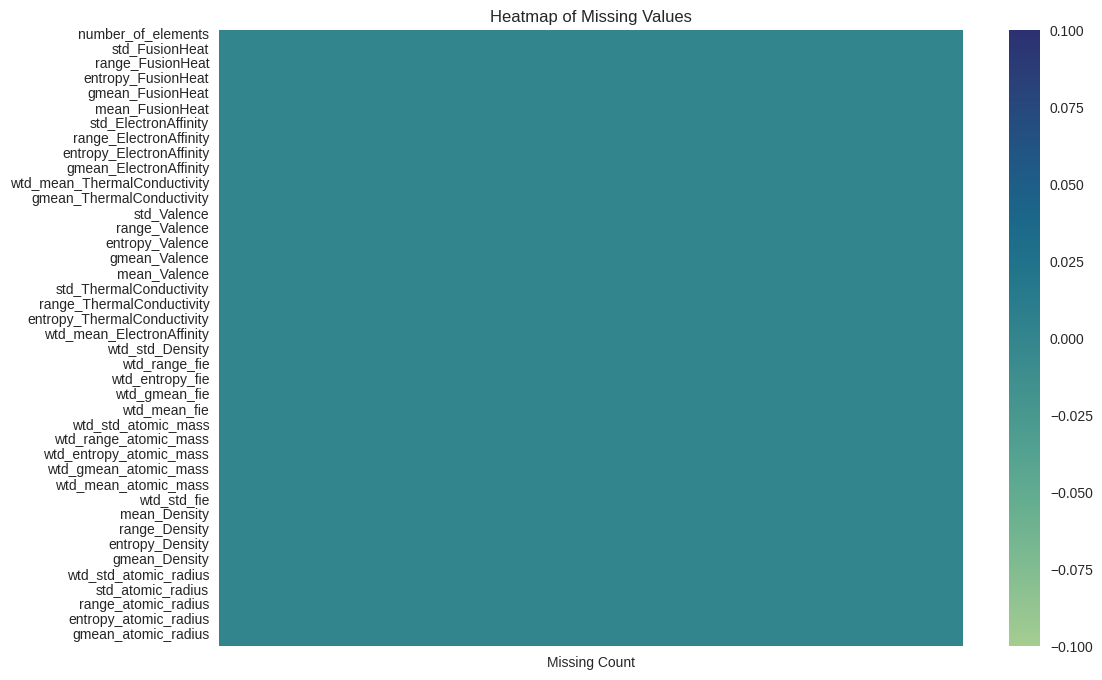

In [ ]:
missing_values_pd = missing_values.toPandas().transpose()
missing_values_pd.columns = ['Missing Count']
missing_values_pd = missing_values_pd.sort_values('Missing Count', ascending=False)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_values_pd, cbar=True, cmap='crest')
plt.title('Heatmap of Missing Values')
plt.show()

We can see that there are no missing values in the dataset.

## **Looking for Outliers**

Next, we will identify any outliers of `critical_temp` values.

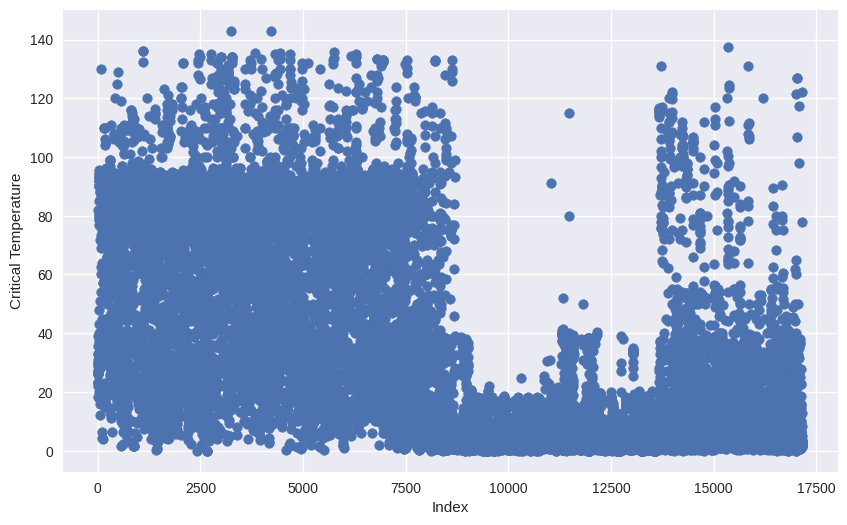

In [ ]:
critical_temp_pd = scCopy.select('critical_temp').toPandas()['critical_temp']
plt.figure(figsize=(10, 6))
plt.scatter(range(len(critical_temp_pd)), critical_temp_pd)
plt.xlabel('Index')
plt.ylabel('Critical Temperature')
plt.show()

It appears there might be some outliers with extremely high critical temperatures. We may investigate these further to determine if they are legitimate data points or errors.


## **Distribution of Features**

Let's visualize the distribution of some of the features to understand their spread and potential outliers.

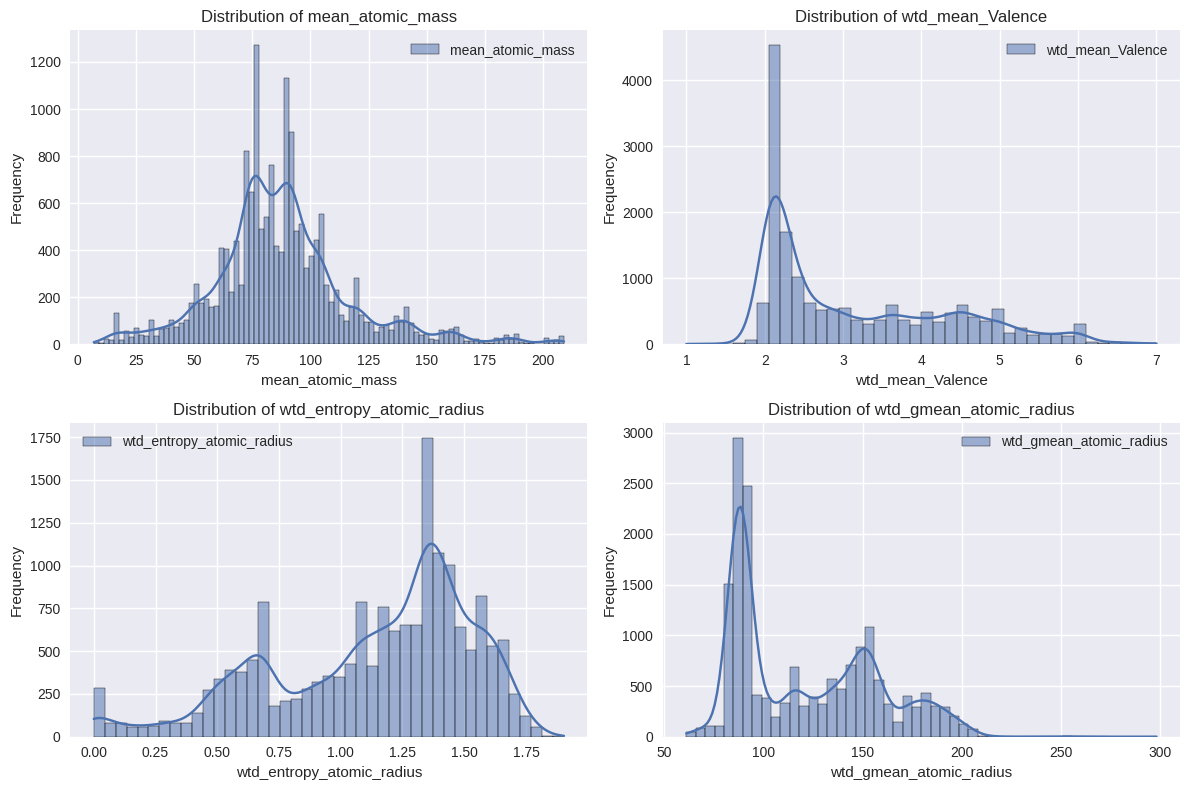

In [ ]:
columns_to_plot = [ 'mean_atomic_mass', 'wtd_mean_Valence', 'wtd_entropy_atomic_radius','wtd_gmean_atomic_radius']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(scCopy.select(col).toPandas(), ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

From here, we can see that most materials in the dataset are concentrated in lower value ranges with fewer instances at higher values. Some features, like the **weighted entropy and weighted geometric mean of atomic radius**, exhibit multimodal distributions, suggesting the presence of distinct subgroups within the dataset. These insights highlight the diversity of the materials represented and may suggest the need for different modeling approaches depending on the specific characteristics of each feature.

## **Looking for Correlations**

We will calculate the standarad correlation coefficient between every pair of attributes using the `corr` method.

In [ ]:
train_df_pandas = scCopy.toPandas()
correlation_matrix = train_df_pandas.corr()

Next, we will look out how much each attributes correlates with `critical_temp`

In [ ]:
correlation_matrix['critical_temp'].sort_values(ascending=False)

,critical_temp
critical_temp,1.000000
wtd_std_ThermalConductivity,0.725426
range_ThermalConductivity,0.690145
range_atomic_radius,0.656680
std_ThermalConductivity,0.656621
...,...
gmean_Density,-0.541375
gmean_Valence,-0.574765
mean_Valence,-0.602165
wtd_gmean_Valence,-0.616470


In a visualize way,

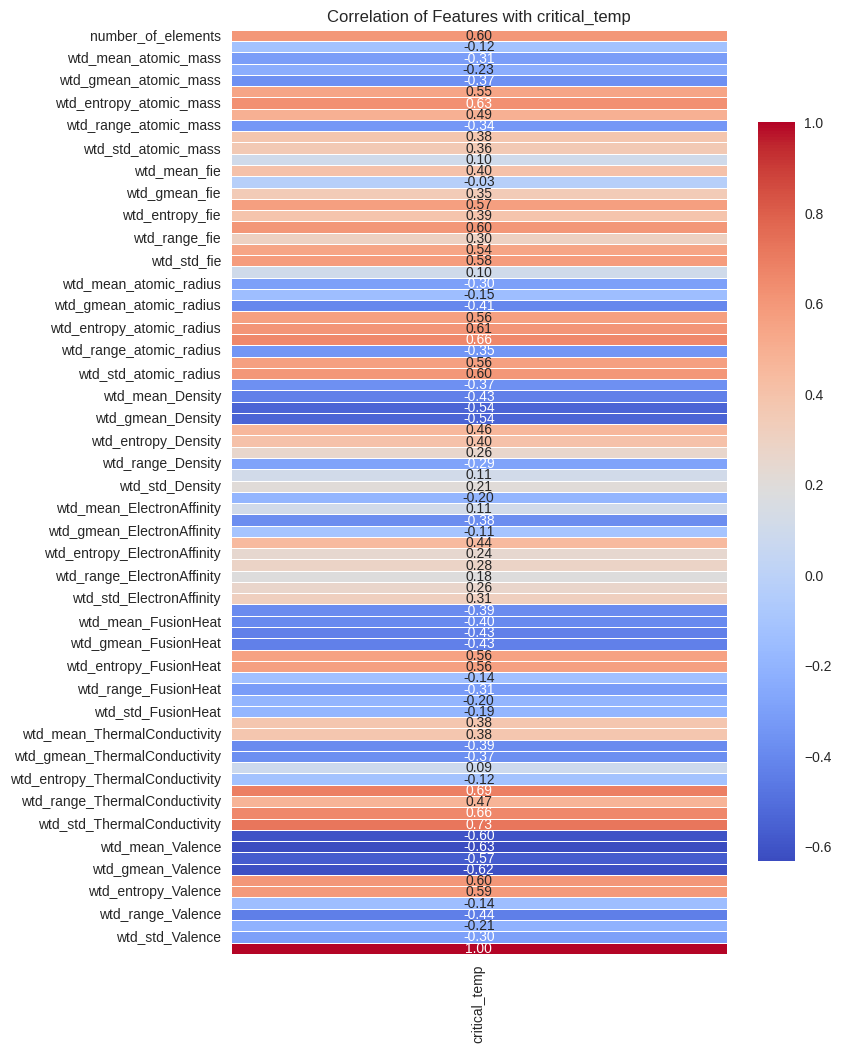

In [ ]:
correlation_with_target = correlation_matrix[['critical_temp']]
plt.figure(figsize=(8, 12))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})
plt.title('Correlation of Features with critical_temp')
plt.xticks(rotation=90)
plt.show()

For further comprehensive exploration, we shall plot out the target variable with the most highest correlation attribute ,`'wtd_std_ThermalConductivity'`.

<Axes: xlabel='wtd_std_ThermalConductivity', ylabel='critical_temp'>

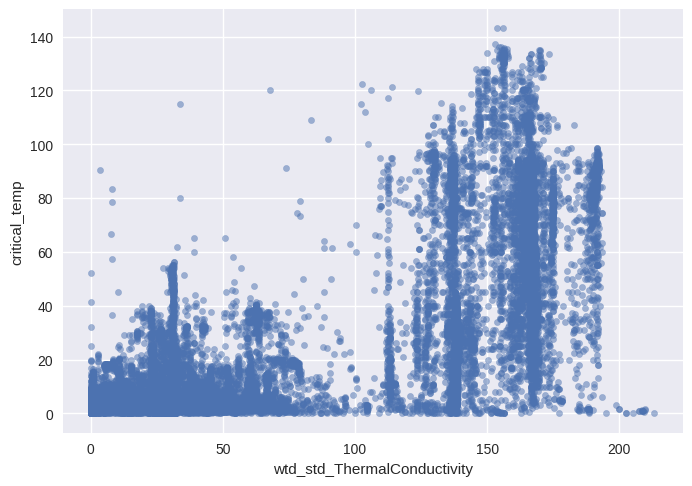

In [ ]:
train_df_pandas.plot(kind="scatter", x="wtd_std_ThermalConductivity", y="critical_temp", alpha=0.5)

From the chart, we can see a somewhat positive correlation. This suggests that materials with higher weighted standard deviation of thermal conductivity tend to have higher critical temperatures. However, the relationship is not perfectly linear, and there is a noticeable spread of data points, indicating other factors also influence critical temperature.

## **Looking for Attribute combinations**

We shall now look attribution combinations before feeding the data into the algorithms.

To identify relationships between features, we can use correlation matrix for better understanding.

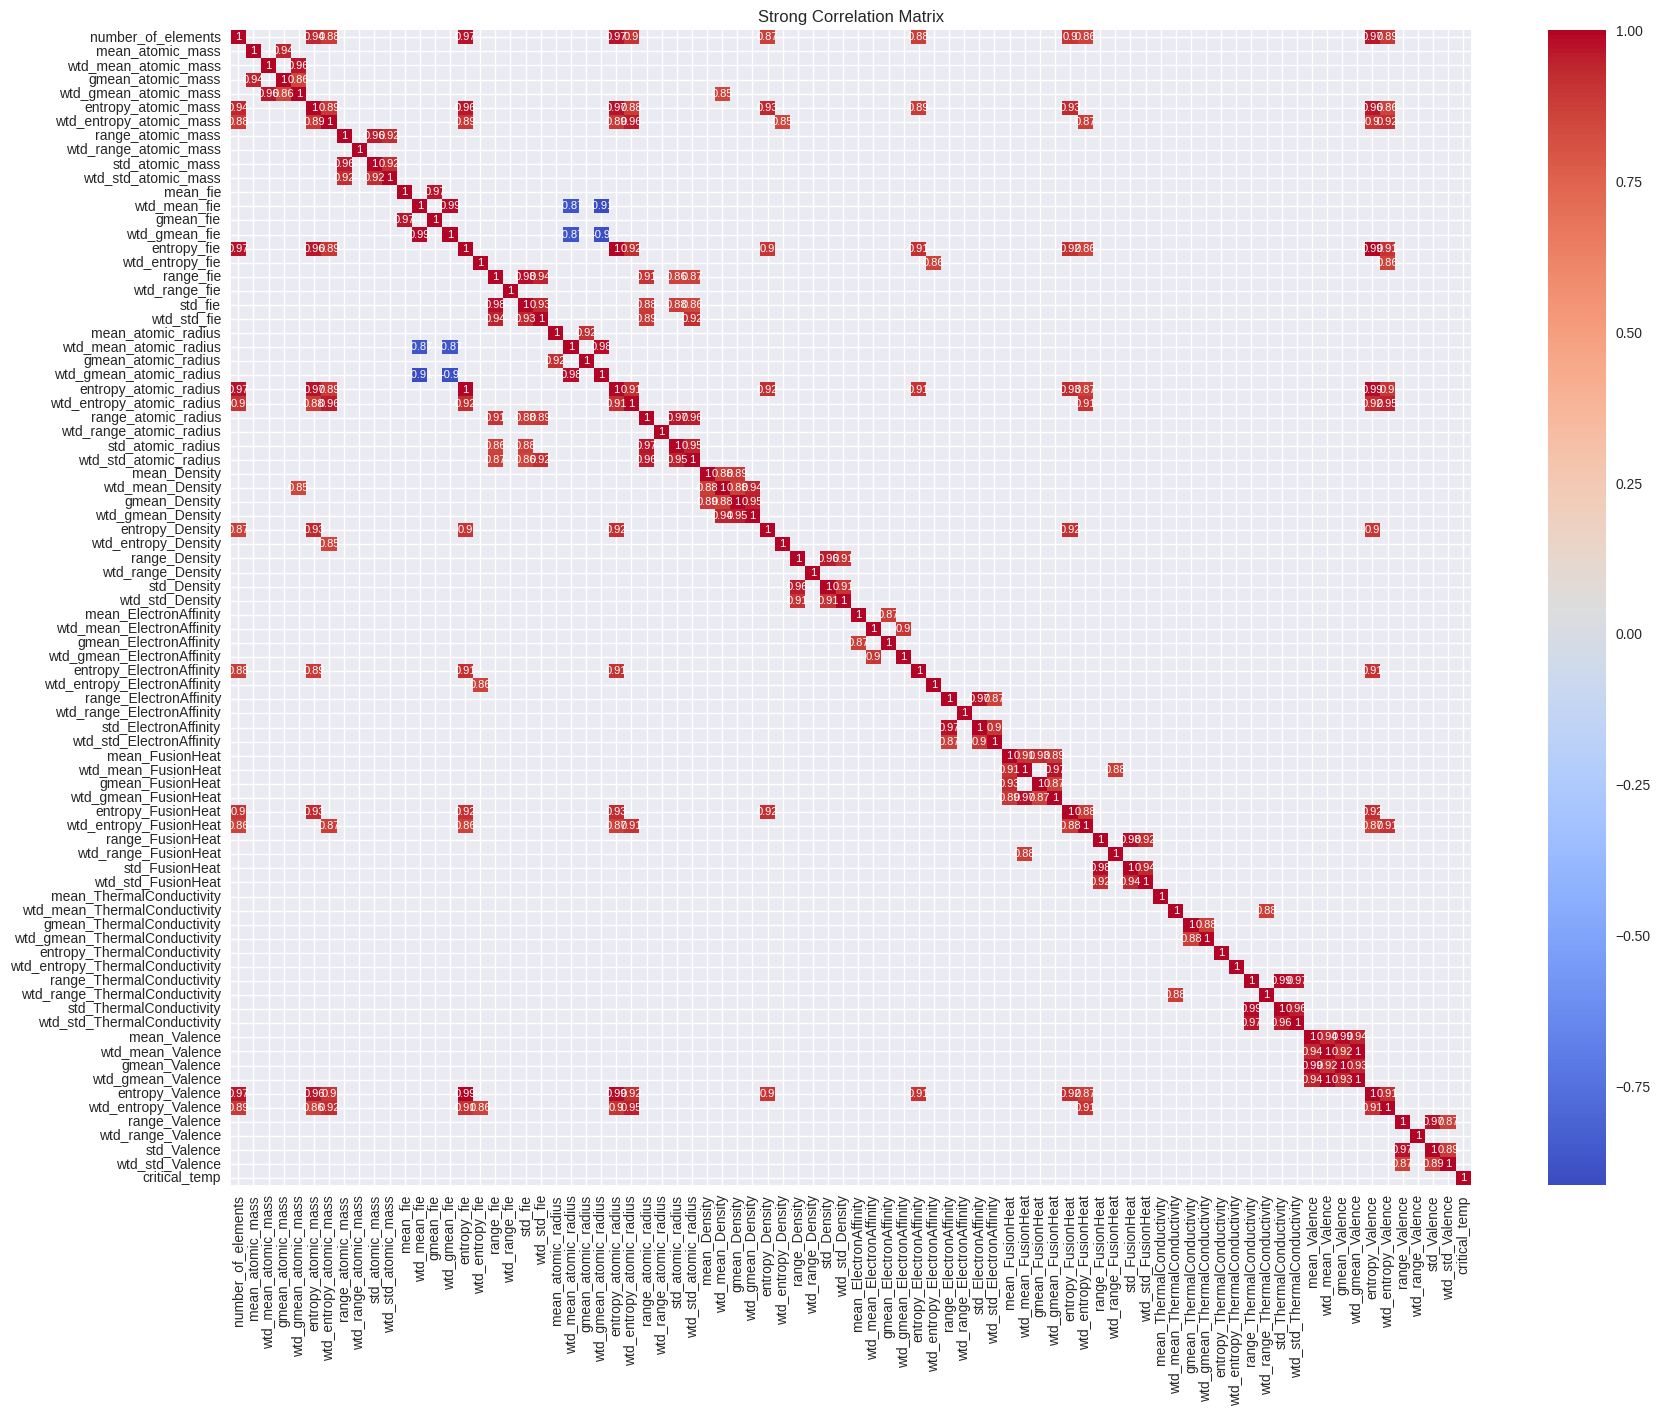

In [ ]:
threshold=0.85
strong_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

plt.figure(figsize=(20, 15))
sns.heatmap(strong_correlations, annot=True, cmap='coolwarm', mask=strong_correlations.isnull(), annot_kws={"size": 8})
plt.title('Strong Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Inisght received from the above matrix is that **wtd_mean_fie** is strongly correlated with **wtd_mean_atomic_mass, wtd_gmean_atomic_radius,** and other related features.

On the other hand, When features are highly correlated, they carry similar information, which could lead to potential multicollinearity. This can cause instability in some types of models, such as linear regression, making it harder to determine the effect of each feature independently. Since "Linear Regression" is one of our selected algorithms, we need to address this by removing or combining correlated features or using regularization techniques.

In [ ]:
np.fill_diagonal(strong_correlations.values, 0)
strong_corr_pairs =strong_correlations.unstack().drop_duplicates().sort_values()
print(strong_corr_pairs)

wtd_mean_fie        wtd_gmean_atomic_radius   -0.913591
wtd_gmean_fie       wtd_gmean_atomic_radius   -0.896744
                    wtd_mean_atomic_radius    -0.870724
wtd_mean_fie        wtd_mean_atomic_radius    -0.869520
number_of_elements  number_of_elements         0.000000
                                                 ...   
wtd_mean_fie        wtd_gmean_fie              0.992402
entropy_fie         entropy_Valence            0.992801
wtd_mean_Valence    wtd_gmean_Valence          0.995016
entropy_fie         entropy_atomic_radius      0.997761
number_of_elements  mean_atomic_mass                NaN
Length: 122, dtype: float64


According to this output, we decided to use "**wtd_mean_fie**" and "**wtd_gmean_atomic_radius**" as combine features to reduce redundancy in the dataset, simplify the model like Linear Regression, and help it perform better by focusing on the most important interactions between features.

## **Target Variable Analysis**

Firstly, we will check our dataset whether it has an imbalanced distribution of the target variable,`critical_temp`.

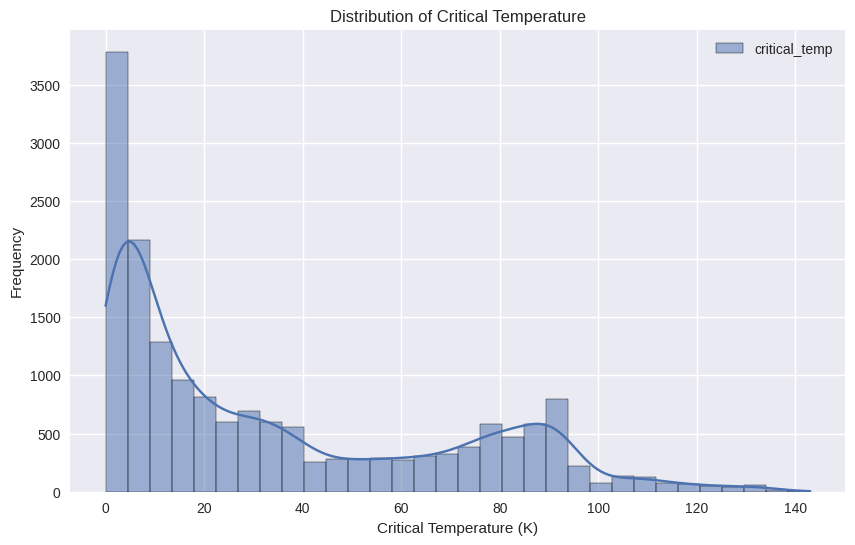

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(scCopy.select('critical_temp').toPandas(), kde=True)
plt.title('Distribution of Critical Temperature')
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Frequency')
plt.show()


Since a large portion of the data is concentrated at the lower temperatures, the dataset is somewhat imbalanced. This might affect to our regression model's performance, particularly if the model is less accurate for the higher temperature ranges due to the fewer data points.

# **(2) (i) Prepare the Data for Machine Learning Algorithms**

Now, we will do data preprocesssing before feeding it into the selected algorithms.

## **Data Cleaning**

As we notice that the outliers are existed, we have to handle outliers. Thus, we will build a custom function to detect outliers.

In [ ]:
def detect_outliers(df: DataFrame, columns=None, factor=1.5):

    if columns is None:
        columns = [column for column, dtype in df.dtypes if dtype in ('int', 'double')]

    for column in columns:
        # Calculate Q1 and Q3
        Q1 = df.approxQuantile(column, [0.25], 0.0)[0]
        Q3 = df.approxQuantile(column, [0.75], 0.0)[0]

        # Calculate IQR
        IQR = Q3 - Q1

        # Calculate lower and upper bounds for outliers
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)

        # Add columns to mark outliers
        outlier_col = f'is_outlier_{column}'
        df = df.withColumn(outlier_col,
                           F.when((df[column] < lower_bound) | (df[column] > upper_bound), 1).otherwise(0))

    return df

In [ ]:
df_with_outliers = detect_outliers(strat_train_set, columns=strat_train_set.columns, factor=1.5)

In [ ]:
df_with_outliers.show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+----------------+-------------------+--------+----------------+----------------+----------------+----------------+-----------------+---------+----------------+----------------+----------------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+----------------+-----------------+-----------------+-------------------+-------------+-----------------+----------------+----------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+---------------


In this specific case, removing outliers from `'critical_temp'` could potentially bias the model towards predicting lower temperatures, as the higher temperature superconductors would be underrepresented in the training data.

Therefore, we decided to keep the outliers for now.

## **User-Defined Transformers**

To streamline the data preprocessing steps and make them reusable, we'll create custom PySpark transformers. These transformers encapsulate specific data transformations, allowing us to apply them consistently to different datasets or within machine learning pipelines.

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

class CustomFeatureTransformer(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol=None, outputCol=None, use_new_feature=True):
        super(CustomFeatureTransformer, self).__init__()
        self.use_new_feature = use_new_feature
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset: DataFrame) -> DataFrame:
        if self.use_new_feature:
            dataset = dataset.withColumn(
                self.outputCol,
                (col('wtd_mean_fie') * col('wtd_gmean_atomic_radius')).cast('double')
            )
        return dataset

## **Feature Preparation**

Before we proceed with traing models and fine-tuning, it's essential to further split our training data into a subset for training and a smaller subset for validation.
This validation set will help us evaluate the model's performance on unseen data during the fine-tuning process and prevent overfitting. We'll use a stratified split again to maintain the distribution of `'critical_temp'` in both the training and validation sets.



In [ ]:
train_data, validation_data =strat_train_set.randomSplit([0.8, 0.2], seed=42)

We are also required to assemble the features into a feature Vector.

In [ ]:
custom_transformer = CustomFeatureTransformer(
    outputCol='new_feature'
)
all_columns = train_data.columns

input_columns = [col for col in all_columns if col != 'critical_temp']

input_columns.append('new_feature')

# Define the VectorAssembler
assembler = VectorAssembler(
    inputCols=input_columns,
    outputCol='features_vector'
)


# Standard Scaler
scaler = StandardScaler(inputCol='features_vector', outputCol='scaled_features')


# **(2) (ii) Select and train models**

Now, we are ready to select and train our selected models with the help of `Pipeline` class to perform transformations sequencially.  After training, we will evaluate their performance on the validation data using the Root Mean Squared Error (RMSE) metric. This process helps us understand how well each model performs with the initial settings before we proceed with fine-tuning. Evaluating the initial models provides a baseline for comparison and helps us identify which models might benefit most from further adjustments.

**Linear Regression**

In [ ]:
# Initialize the evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="critical_temp", metricName="rmse")

In [ ]:
# Define the Linear Regression Model
lr = LinearRegression(featuresCol='scaled_features', labelCol='critical_temp')

# Create the pipeline with the corrected order
pipeline_lr_initial = Pipeline(stages=[ custom_transformer,assembler, scaler, lr])
print("Training initial Linear Regression Model...")
lr_model_initial = pipeline_lr_initial.fit(train_data)

print("Evaluating initial Linear Regression Model...")
lr_predictions_initial = lr_model_initial.transform(validation_data)

lr_rmse_initial = evaluator.evaluate(lr_predictions_initial)
print(f'Initial Linear Regression RMSE: {lr_rmse_initial}')


Training initial Linear Regression Model...
Evaluating initial Linear Regression Model...
Initial Linear Regression RMSE: 17.578192878991587


**Decision Tree**

In [ ]:
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='critical_temp')
pipeline_dt_initial = Pipeline(stages=[custom_transformer,assembler,scaler,dt])
print("Training initial Decision Tree Model...")
dt_model_initial = pipeline_dt_initial.fit(train_data)
print("Evaluating initial Decision Tree Model...")
dt_predictions_initial = dt_model_initial.transform(validation_data)
dt_rmse_initial = evaluator.evaluate(dt_predictions_initial)
print(f'Initial Decision Tree RMSE: {dt_rmse_initial}')

Training initial Decision Tree Model...
Evaluating initial Decision Tree Model...
Initial Decision Tree RMSE: 16.815582260219728


**Random Forest**

In [ ]:
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='critical_temp')
pipeline_rf_initial = Pipeline(stages=[custom_transformer,assembler,scaler,rf])

print("Training initial Random Forest Model...")
rf_model_initial = pipeline_rf_initial.fit(train_data)

print("Evaluating initial Random Forest Model...")
rf_predictions_initial = rf_model_initial.transform(validation_data)

rf_rmse_initial = evaluator.evaluate(rf_predictions_initial)
print(f'Initial Random Forest RMSE: {rf_rmse_initial}')

Training initial Random Forest Model...
Evaluating initial Random Forest Model...
Initial Random Forest RMSE: 15.090803766282116


By comparing all of their performance,

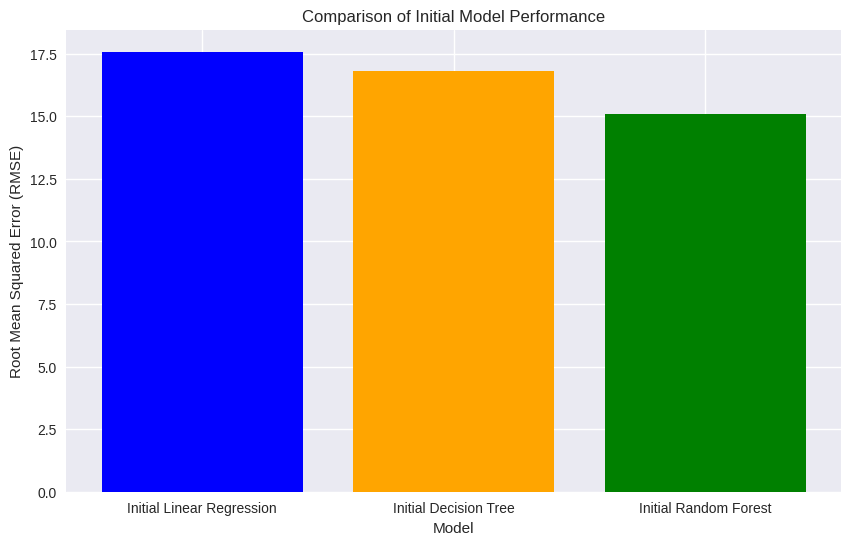

In [ ]:
models_initial = ['Initial Linear Regression', 'Initial Decision Tree', 'Initial Random Forest']
rmses_initial = [lr_rmse_initial, dt_rmse_initial, rf_rmse_initial]

# Plot the RMSE values for initial models
plt.figure(figsize=(10, 6))
plt.bar(models_initial, rmses_initial, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Initial Model Performance')
plt.show()

we can see that, the Initial Linear Regression model has the highest RMSE, indicating it performs the worst among the three models with an error close to 18. The Decision Tree model shows a slightly better performance with an RMSE around 16. The Initial Random Forest model outperforms both, achieving the lowest RMSE below 15. These results suggest that the Random Forest model is more effective in predicting the target variable in this dataset, potentially due to its ability to handle complex, non-linear relationships and interactions between features.

Thus, we will furhter tune those three models to see whether it might improve performance.

# **(2) (iii) Fine-tune the models**

In the fine-tuning phase of our modeling process, the goal is to optimize the performance of the machine learning models by adjusting their hyperparameters.

**Linear Regression**

In [ ]:
pipelineLR = Pipeline(stages=[custom_transformer,assembler, scaler, lr])

paramGridLR = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.001, 0.0001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.9, 1.0]) \
    .build()

cvLR = CrossValidator(estimator=pipelineLR, estimatorParamMaps=paramGridLR, evaluator=RegressionEvaluator(labelCol='critical_temp'), numFolds=5)
modelLR = cvLR.fit(train_data)

predLR = modelLR.transform(validation_data)
rmseLR = RegressionEvaluator(labelCol='critical_temp').evaluate(predLR)

print(f"Tuned Linear Regression RMSE: {rmseLR}")

Tuned Linear Regression RMSE: 17.577811894957094


**DecisionTree**

In [ ]:
pipelineDT = Pipeline(stages=[custom_transformer,assembler, scaler, dt])

paramGridDT = ParamGridBuilder().addGrid(dt.maxDepth, [3,5,7,10]).addGrid(dt.minInstancesPerNode, [2, 5, 10]).build()

cvDT = CrossValidator(estimator=pipelineDT, estimatorParamMaps=paramGridDT, evaluator=RegressionEvaluator(labelCol='critical_temp'), numFolds=5)

modelDT = cvDT.fit(train_data)

predDT = modelDT.transform(validation_data)

rmseDT = RegressionEvaluator(labelCol='critical_temp').evaluate(predDT)

print(f"Decision Tree RMSE: {rmseDT}")


Decision Tree RMSE: 13.205156614717504


**Random Forest**

In [ ]:
pipelineRF = Pipeline(stages=[custom_transformer,assembler, scaler, rf])

paramGridRF = ParamGridBuilder().addGrid(rf.numTrees, [20, 50, 100]).addGrid(rf.maxDepth, [10, 15, 20]).addGrid(rf.maxBins, [32, 64]).build()

cvRF = CrossValidator(estimator=pipelineRF, estimatorParamMaps=paramGridRF, evaluator=RegressionEvaluator(labelCol='critical_temp'), numFolds=5)

modelRF = cvRF.fit(train_data)

predRF = modelRF.transform(validation_data)

rmseRF = RegressionEvaluator(labelCol='critical_temp').evaluate(predRF)

print(f"Random Forest RMSE: {rmseRF}")

Random Forest RMSE: 9.407116046647785


#**(2) (iv) Evaluate the outcomes**

Now, it is all about the time to evaluate the final model on the test set.

In [ ]:
# evaluate RMSE for each model
test_predLR = modelLR.transform(strat_test_set)

test_rmseLR = evaluator.evaluate(test_predLR)
print(f"Linear Regression RMSE: {test_rmseLR}")

Linear Regression RMSE: 18.182813377614913


In [ ]:
test_predDT = modelDT.transform(strat_test_set)
test_rmseDT = evaluator.evaluate(test_predDT)
print(f"Decision Tree RMSE: {test_rmseDT}")

Decision Tree RMSE: 13.534957363911984


In [ ]:
test_predRF = modelRF.transform(strat_test_set)
test_rmseRF = evaluator.evaluate(test_predRF)
print(f"Random Forest RMSE: {test_rmseRF}")

Random Forest RMSE: 10.152368368208327


## **(5) A comparison of models' performance**

In [ ]:
evaluator_r2 = RegressionEvaluator(labelCol='critical_temp', predictionCol='prediction', metricName='r2')
lr_r2 = evaluator_r2.evaluate(test_predLR)
dt_r2 = evaluator_r2.evaluate(test_predDT)
rf_r2 = evaluator_r2.evaluate(test_predRF)

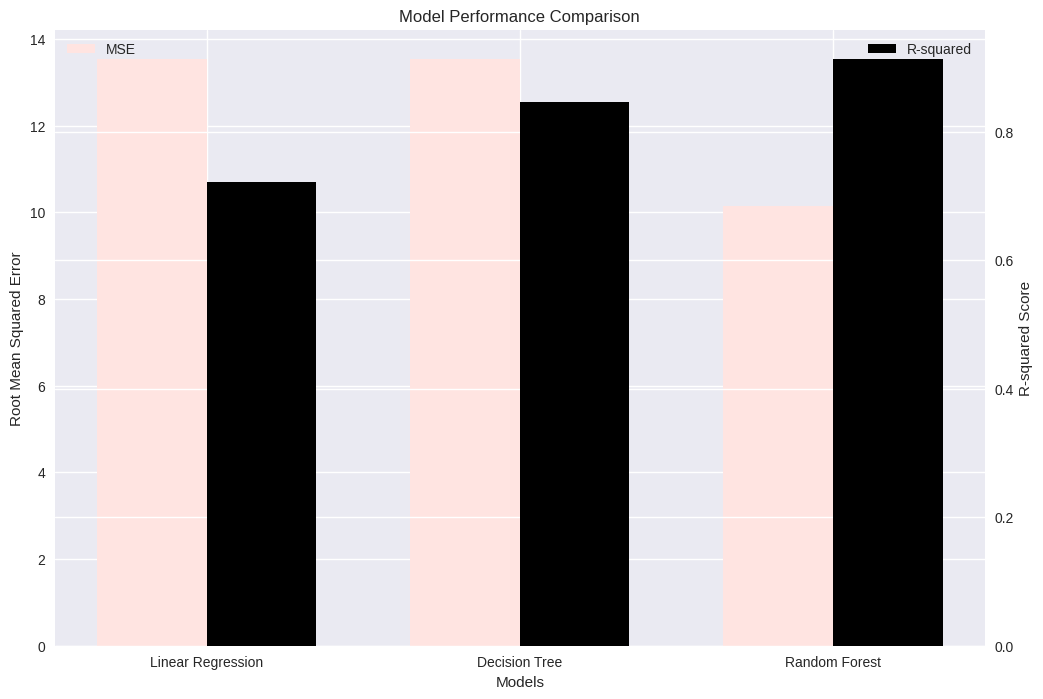

In [ ]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
rmse_values = [test_rmseDT, test_rmseDT, test_rmseRF]
r2_values = [lr_r2, dt_r2, rf_r2]

#the positions and width for the bars
x = np.arange(len(models))
width = 0.35


fig, ax1 = plt.subplots(figsize=(12, 8))

bar1 = ax1.bar(x - width/2, rmse_values, width, label='MSE', color='MistyRose')
ax1.set_xlabel('Models')
ax1.set_ylabel('Root Mean Squared Error')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')

#a secondary y-axis for the R-squared values
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2_values, width, label='R-squared', color='black')
ax2.set_ylabel('R-squared Score')
ax2.legend(loc='upper right')

plt.show()

From the chart which used two metrics($RMSE$ and $R^2$), we can see that the Random Forest model stands out as the best performer, with the lowest RMSE and the highest R-squared score among the three models. This indicates that Random Forest is the most accurate in predicting the target variable and explains the highest amount of variance in the data.The Decision Tree model, while not as strong as Random Forest, still performs reasonably well with a moderate RMSE and R-squared score, indicating it captures some, but not all, of the data's variability. On the contrary, the Linear Regression model has the highest RMSE and lowest R-squared score, indicating it performs the worst in predicting the target variable.

We can also see comparison of the actual and predicted values for all three models as well.

In [ ]:
print("Sample Predictions from Linear Regression Model:")
test_predLR.select("prediction", "critical_temp").show(5)

print("Sample Predictions from Decision Tree Model:")
test_predDT.select("prediction", "critical_temp").show(5)

print("Sample Predictions from Random Forest Model:")
test_predRF.select("prediction", "critical_temp").show(5)

Sample Predictions from Linear Regression Model:
+------------------+-------------+
|        prediction|critical_temp|
+------------------+-------------+
|26.068111986903507|         19.0|
|  48.4006442384009|         11.0|
|24.700762131873272|         36.0|
|39.181399693005744|         27.0|
|18.949660718681574|         14.8|
+------------------+-------------+
only showing top 5 rows

Sample Predictions from Decision Tree Model:
+------------------+-------------+
|        prediction|critical_temp|
+------------------+-------------+
|          24.86875|         19.0|
| 51.31666666666667|         11.0|
| 35.72546511627907|         36.0|
| 20.24545454545453|         27.0|
|12.275916666666669|         14.8|
+------------------+-------------+
only showing top 5 rows

Sample Predictions from Random Forest Model:
+------------------+-------------+
|        prediction|critical_temp|
+------------------+-------------+
|26.414038817924105|         19.0|
|58.181767857142866|         11.0|
|35.36

When we generated out the predictions, we can obviously see that the Random Forest model demonstrates superior predictive performance, producing predictions that are closest to the actual values, followed by the Decision Tree model. The Linear Regression model, while providing reasonable predictions, tends to have larger deviations, indicating it might not be the best fit for this dataset's complexity.

#**(6) Report of comparison Between Spark MLlib and Scikit-Learn**

Based on our experience in the assignments, the following are the information of pros and cons,similarity and differences what we found out throughout the project.

## **Pros and Cons of `Spark MLlib`:**



**Pros:**


---


**Scalability**: Efficiently handles large-scale datasets using distributed computing.

**Integration**: Seamlessly integrates with the Apache Spark ecosystem, facilitating large-scale data processing.

**Performance**: Optimized for performance with built-in support for parallel processing.



\
**Cons**:


---


**Complexity**: Setting up and managing Spark can be more complex and requires a distributed computing environment.

**Limited Algorithms**: May lack some advanced algorithms and techniques available in other libraries.

**Slower Experimentation**: Development and model experimentation can be slower due to the need for distributed resources.


## **Prons and Cons of `Scikit-Learn`**:


**Pros:**



---





**Ease of Use**: User-friendly API and comprehensive documentation make it easy to implement and experiment with various models.

**Integration**: Works well with NumPy, Pandas, and other scientific libraries, enhancing data science workflows.

**Rich Ecosystem**: Supports a wide range of algorithms and tools for machine learning and model evaluation.



\

**Cons**:


---


**Scalability Limitations**: Struggles with very large datasets due to limited support for distributed computing.

**Memory Constraints**: Suitable mainly for datasets that fit into memory, potentially limiting its use with larger data.

## **The Similarity and differences of` Spark MLlib` and `Scikit-Learn`**

**Similarities**:


---


**Machine Learning Algorithms**: Both libraries offer a broad range of machine learning algorithms, including classification, regression, and clustering.

**Model Evaluation**: They provide tools for model evaluation, including metrics like accuracy, precision, recall, and RMSE.

**Data Preprocessing**: Both support various data preprocessing techniques, such as scaling, encoding, and splitting datasets.

\
**Differences**:


---


**Scalability**: Spark MLlib excels in distributed computing for large-scale data, whereas Scikit-Learn is optimized for single-machine use.

**Ease of Setup**: Scikit-Learn is simpler to set up and use for individual projects, while Spark MLlib requires a more complex distributed environment.

**Integration**: Spark MLlib is tightly integrated with the Spark ecosystem, useful for big data applications, while Scikit-Learn integrates seamlessly with Python’s scientific stack for general-purpose machine learning.

# **Conclusion**

In this task, we compared the performance of three machine learning models(**Linear Regression, Decision Tree, and Random Forest**)using the Spark MLlib library to predict critical temperature. Our analysis mainly focused on an exploration of the dataset, feature engineering, model training, and evaluation.

In every parts, we strongly prsented and highlighted our insights of effectiveness of ensemble methods, such as Random Forest, in handling complex datasets by averaging the outcomes of multiple decision trees to reduce prediction errors. This model demonstrated superior performance, making it the most suitable choice for our predictive task.

Furthermore, our comparison between Spark MLlib and Scikit-Learn emphasized the strengths and limitations of each library. While Spark MLlib excels in distributed computing for large-scale data, Scikit-Learn offers simplicity and ease of use for smaller, individual projects.

Overall, this task provided a comprehensive overview of leveraging Spark MLlib for machine learning, from data preprocessing and feature engineering to model training and evaluation, demonstrating its capabilities in handling large datasets and complex predictive tasks effectively.